In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Constants:
    R = 8.314472                 # J/mol.K
    T0K = 273.15                 # K

In [3]:
class Conditions:
    p0 = 1.01325e5                # Pa
    T0 = 0 + Constants.T0K        # K

In [4]:
class Water:
    M = 18.0153e-3               # Kg/mol
    Tvap = 99.94 + Constants.T0K # K
    cp = 1.826e3                 # J/kg.K
    Hv = 40.662e3                # J/mol
    lv = Hv/M                    # J/Kg

In [5]:
class Air:
    M = 28.6953e-3               # Kg/mol
    cp = 1.006e3                 # J/Kg.K

In [6]:
class Mix:
    
    C = Constants
    CSTP = Conditions
    gas = Air
    liquid = Water
    
    Mr = liquid.M/gas.M
    
    def psat(T):
        return Mix.CSTP.p0*np.exp(-Mix.liquid.Hv/Mix.C.R*(1/T - 1/Mix.liquid.Tvap))
    
    def pw(T, phi=1.):
        return phi*Mix.psat(T)
    
    def pisov(T, v):
        return Mix.CSTP.p0 - (Mix.C.R*T)/(Mix.gas.M*v)
    
    def pisoh(T, h):
        dT = (T - Mix.CSTP.T0)
        return Mix.CSTP.p0*(h - Mix.gas.cp*dT)/\
                ((h + Mix.Mr*Mix.liquid.lv) + (Mix.Mr*Mix.liquid.cp - Mix.gas.cp)*dT)

    def plot(T=None):
        
        # Temperature:
        if T is None:
            T = np.linspace(0, 35) + Constants.T0K
        
        # Curves:
        psat = Mix.psat(T)/1000.
        pphi = np.array([Mix.pw(T, phi=phi)/1000. for phi in np.arange(0.1, 0.91, 0.1)]).T
        pisov = np.array([(Mix.pisov(T, v=v)/1000.) for v in np.arange(0.70, 1.11, 0.01)]).T
        pisoh = np.array([(Mix.pisoh(T, h=h)/1000.) for h in np.arange(-1e4, 18.1e4, 1e4)]).T
        
        # Figure:
        fig, axe = plt.subplots()
        axe.plot(T, psat, label=r"Saturation: $p_\mathrm{sat}(T)$", color='black', linewidth=2.5)
        axe.plot(T, pphi, color='black', linewidth=0.5)
        axe.plot(T, pisov, color='blue', linewidth=0.5)
        axe.plot(T, pisoh, color='purple', linewidth=0.5)
        axe.set_title(r"{} Psychrometric Chart: $p_0 = {:.3f}$ $[\mathrm{{kPa}}]$".format(
            Mix.liquid.__name__, Mix.CSTP.p0/1000.))
        axe.set_xlabel(r"Temperature, $T$ $[\mathrm{K}]$")
        axe.set_ylabel(r"Partial Pressure, $p_w$ $[\mathrm{kPa}]$")
        axe.legend(bbox_to_anchor=(1,1), loc='upper left')
        axe.set_xlim(T[[0,-1]])
        axe.set_ylim([0, 4])
        axe.grid()
        return axe

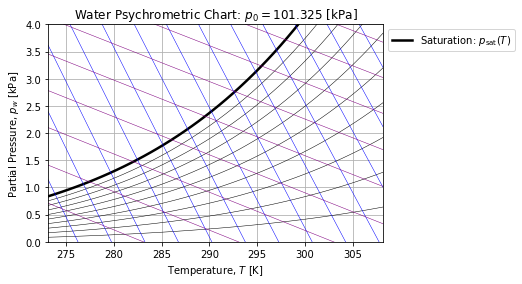

In [7]:
axe = Mix.plot()

In [8]:
df = pd.read_csv('Psychro_data.csv', header=[0,1], index_col=0, parse_dates=[0])
df.iloc[:6,:6]

channel             battery_status                                          \
device_name              node-T001 node-T002 node-T003 node-T004 node-T005   
timestamp                                                                    
2019-10-26 18:15:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 18:30:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 18:45:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:00:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:15:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:30:00            3.0       3.0       3.0       3.0       NaN   

channel             battery_voltage  
device_name               node-T001  
timestamp                            
2019-10-26 18:15:00        3.108000  
2019-10-26 18:30:00        3.106667  
2019-10-26 18:45:00        3.106000  
2019-10-26 19:00:00        3.106000  
2019-10-26 19:15:00        3.105333  
2019-10-26 19:30:00        3.104000

In [9]:
T = df['node_temperature'] + Constants.T0K
T.columns = pd.MultiIndex.from_product([['T'], T.columns])
T.head()

T                                            
                      node-T001   node-T002 node-T003   node-T004 node-T005
timestamp                                                                  
2019-10-26 18:15:00  291.265000  293.345000    293.20  294.885000       NaN
2019-10-26 18:30:00  291.226667  293.303333    293.16  294.863333       NaN
2019-10-26 18:45:00  291.203333  293.263333    293.13  294.840000       NaN
2019-10-26 19:00:00  291.290000  293.240000    293.10  294.813333       NaN
2019-10-26 19:15:00  291.206667  293.200000    293.07  294.786667       NaN

In [10]:
RH = df['node_humidity']/100.
RH.columns = pd.MultiIndex.from_product([['RH'], RH.columns])
RH.head()

RH                                        
                    node-T001 node-T002 node-T003 node-T004 node-T005
timestamp                                                            
2019-10-26 18:15:00  0.599500  0.741500  0.736500  0.691000       NaN
2019-10-26 18:30:00  0.601333  0.739333  0.734667  0.692000       NaN
2019-10-26 18:45:00  0.606667  0.739333  0.734000  0.691333       NaN
2019-10-26 19:00:00  0.607000  0.738333  0.733000  0.691333       NaN
2019-10-26 19:15:00  0.609000  0.736333  0.731667  0.692000       NaN

In [11]:
pw = pd.DataFrame(Mix.pw(T.values , phi=RH.values)/1000., columns = T['T'].columns, index = T.index)
pw.columns = pd.MultiIndex.from_product([['pw'], pw.columns])
pw.head()

pw                                        
                    node-T001 node-T002 node-T003 node-T004 node-T005
timestamp                                                            
2019-10-26 18:15:00  1.528387  2.129416  2.097691  2.164907       NaN
2019-10-26 18:30:00  1.529676  2.118171  2.087712  2.165399       NaN
2019-10-26 18:45:00  1.541168  2.113359  2.082260  2.160476       NaN
2019-10-26 19:00:00  1.549739  2.107702  2.075875  2.157237       NaN
2019-10-26 19:15:00  1.547393  2.097216  2.068563  2.156079       NaN

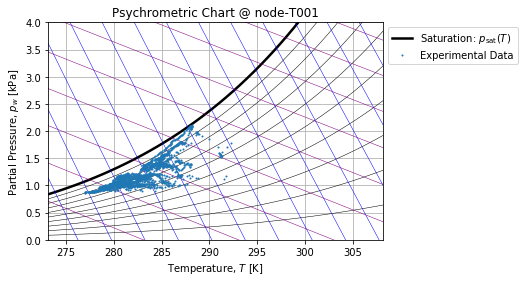

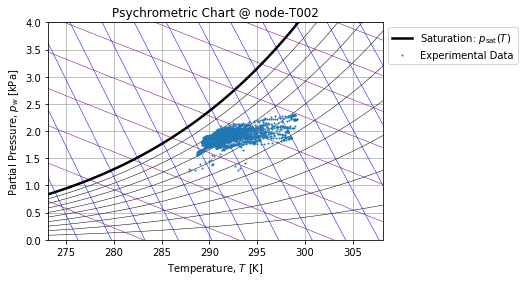

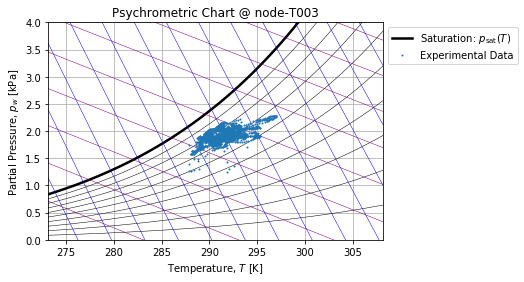

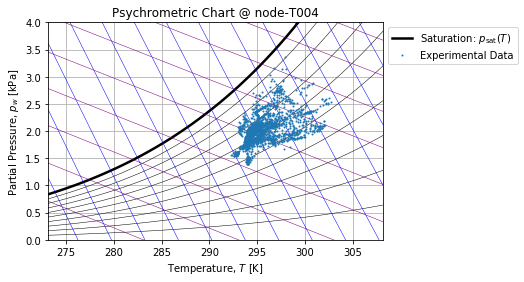

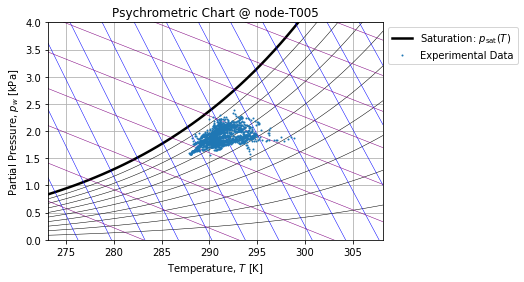

In [12]:
for k in T.columns.levels[-1]:
    idx = pd.IndexSlice[:,k]
    axe = Mix.plot()
    #axe.set_title(r"{} @ {}".format(axe.get_title(), k))
    axe.set_title(r"Psychrometric Chart @ {}".format(k))
    axe.plot(T.loc[:,idx].values.ravel(), pw.loc[:,idx].values.ravel(), '.', markersize=2, label='Experimental Data')
    axe.legend(bbox_to_anchor=(1,1), loc='upper left')